## Baseline Model for Central Arctic Region

This notebook provides the baseline model of the central arctic region.

Before building a trainable model it would be good to have a performance baseline model for comparison with the more complicated models.

Here the dataset is splitted in to two, train and test datasets. First we train the data with train dataset and then test with test dataset.

Calculated the monthly mean of the sea ice extent for the train period and used the monthly mean for the prediction. Here we used RMSE(Root Mean Squared Error) an an evaluation metric.

In [22]:
#import of the neccessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ftplib import FTP
import os
import warnings
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.facecolor':'white'})

In [2]:
df_m = pd.read_csv('data/Central_Arctic.csv')
df_m.head(2)

,datetime,Central_Arctic,Northern_Hemisphere,date,year,month,day,dayofyear,Central_Arctic_Detrend
0,2006-01-01,3225371.74,13034723.95,2006-01-01,2006,1,1,1,NaN
1,2006-01-02,3225371.74,13034723.95,2006-01-02,2006,1,2,2,NaN


In [3]:
df_CA= df_m[['datetime','Central_Arctic']]


In [4]:
df_CA.head(2)

,datetime,Central_Arctic
0,2006-01-01,3225371.74
1,2006-01-02,3225371.74


In [5]:
df_CA['date'] = pd.to_datetime(df_CA['datetime'])
df_CA.drop('datetime', axis=1, inplace=True)
df_CA.describe()

,Central_Arctic
count,5.865000e+03
mean,3.163874e+06
std,1.127491e+05
min,2.483819e+06
25%,3.149527e+06
50%,3.203038e+06
75%,3.232191e+06
max,3.248013e+06


In [6]:
df_CA.head(2)

,Central_Arctic,date
0,3225371.74,2006-01-01
1,3225371.74,2006-01-02


In [7]:
df_CA.shape

(5865, 2)

In [8]:
# first create a DataFrame with all dates between specified start<-->end using pd.date_range()
all_dates_CA = pd.DataFrame(pd.date_range(df_CA['date'].min(), df_CA['date'].max()), columns=['date'])

# from the all_dates DataFrame, left join onto the DataFrame with missing dates
df_CA = all_dates_CA.merge(right=df_CA, how='left', on='date')

# filling the NaN values with the values of the day before
df_CA.fillna(method='ffill', inplace=True)
df_CA = df_CA.reset_index(drop=True)

df_CA.tail()

,date,Central_Arctic
5903,2022-03-01,3248012.93
5904,2022-03-02,3248012.93
5905,2022-03-03,3248012.93
5906,2022-03-04,3248012.93
5907,2022-03-05,3248012.93


In [9]:
df_CA.shape

(5908, 2)

In [10]:
# split into train and test sets (we use 2019-now as test-data)

X_CA = df_CA['Central_Arctic']
train_size_CA = int(len(X_CA)*0.8038)
train_CA, test_CA = X_CA[1:train_size_CA], X_CA[train_size_CA:]

print('Observations: %d' % (len(X_CA)))
print('Training Observations: %d' % (len(train_CA)))
print('Testing Observations: %d' % (len(test_CA)))

Observations: 5908
Training Observations: 4747
Testing Observations: 1160


In [11]:
# Extract additional features from timestamp column
df_CA = df_CA.assign(
    year = lambda x: x['date'].dt.year,
    month = lambda x: x['date'].dt.month,
    day = lambda x: x['date'].dt.day,
    dayofyear = lambda x: x['date'].dt.dayofyear
)
df_CA.head(2)

,date,Central_Arctic,year,month,day,dayofyear
0,2006-01-01,3225371.74,2006,1,1,1
1,2006-01-02,3225371.74,2006,1,2,2


In [12]:
#dataframe for the test-split
df_CA_test = df_CA.iloc[-1160:]
df_CA_test['extent_pred'] = np.nan
df_CA_test.head()

,date,Central_Arctic,year,month,day,dayofyear,extent_pred
4748,2019-01-01,3197901.10,2019,1,1,1,NaN
4749,2019-01-02,3223012.20,2019,1,2,2,NaN
4750,2019-01-03,3210909.96,2019,1,3,3,NaN
4751,2019-01-04,3216735.64,2019,1,4,4,NaN
4752,2019-01-05,3212404.41,2019,1,5,5,NaN


In [14]:
#dataframe for the train-split
df_CA_train = df_CA.iloc[:-1160]
df_CA_train.tail()

,date,Central_Arctic,year,month,day,dayofyear
4743,2018-12-27,3196779.95,2018,12,27,361
4744,2018-12-28,3192352.03,2018,12,28,362
4745,2018-12-29,3195164.66,2018,12,29,363
4746,2018-12-30,3201835.05,2018,12,30,364
4747,2018-12-31,3194383.04,2018,12,31,365


In [16]:
extent_predict=df_CA_train.groupby('month')['Central_Arctic'].mean()
extent_predict

month
1     3.204558e+06
2     3.208834e+06
3     3.222635e+06
4     3.233494e+06
5     3.220621e+06
6     3.210524e+06
7     3.170710e+06
8     3.087576e+06
9     2.973066e+06
10    3.103799e+06
11    3.181201e+06
12    3.200519e+06
Name: Central_Arctic, dtype: float64

In [17]:
for months in range(1,13):
    for ind in range(4748, 4748+len(df_CA_test['month'])):
        if df_CA_test['month'][ind]==months:
           # print(ind, df_test['extent'][ind],extent_predict[months])
           #df_test['extent'][i] = extent_predict[months]
           #print(df_test['extent'][i], extent_predict[months])
            df_CA_test['extent_pred'][ind] = extent_predict[months]

df_CA_test.head()

,date,Central_Arctic,year,month,day,dayofyear,extent_pred
4748,2019-01-01,3197901.10,2019,1,1,1,3.204558e+06
4749,2019-01-02,3223012.20,2019,1,2,2,3.204558e+06
4750,2019-01-03,3210909.96,2019,1,3,3,3.204558e+06
4751,2019-01-04,3216735.64,2019,1,4,4,3.204558e+06
4752,2019-01-05,3212404.41,2019,1,5,5,3.204558e+06


In [25]:
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)

In [26]:
#general plot settings
font = {'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('figure',figsize=(16, 9)) 
plt.rcParams['axes.labelweight'] = 'bold'

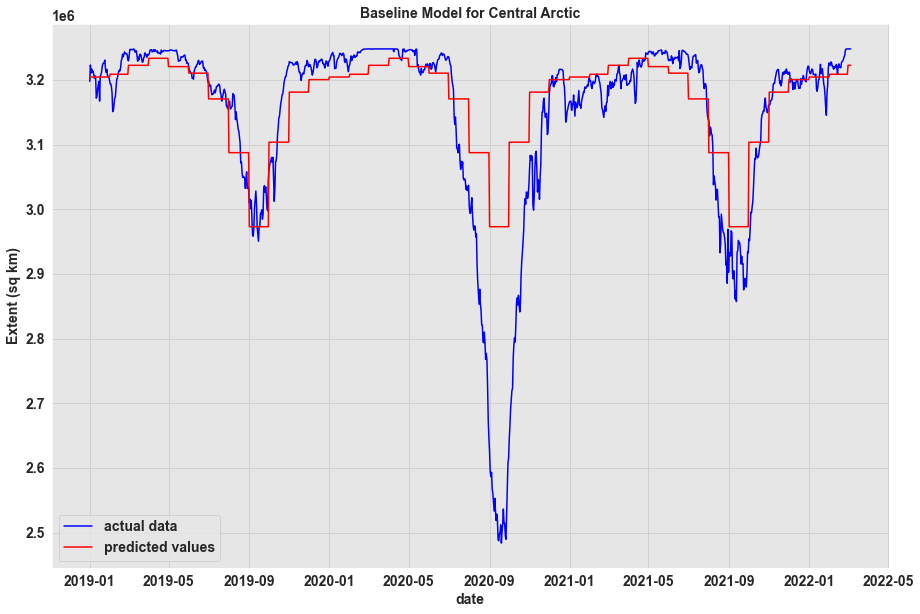

In [29]:
#plotting actual values and predicted values together
plt.figure(figsize=(15,10))

plt.xlabel('date')
plt.ylabel('Extent (sq km)')
plt.plot(df_CA_test['date'], df_CA_test['Central_Arctic'], 'b', label='actual data')
plt.plot(df_CA_test['date'], df_CA_test['extent_pred'], 'r', label='predicted values')
plt.legend()
plt.title('Baseline Model for Central Arctic', fontdict=font)
plt.savefig('images/Baseline_CA.png');

In [21]:
print('RMSE: ' + str(round(mean_squared_error(df_CA_test['Central_Arctic'], df_CA_test['extent_pred'], squared=False),3)))

RMSE: 100204.264
